# GHG emissions of the EU and its member states since 1990

This notebooks details the data preparation and plotting of chart showing the evolution of greenhouse gas emissions EU member states and the EU as whole over time.

## Load prerequisities

This notebooks uses the Tidyverse libraries and the `eurostat` package. To install these libraries, run the command `install.packages(c("eurostat", "tidyverse"))` in your R instance.

In [85]:
library(eurostat)
library(tidyverse)

theme_set(theme_minimal())

## Parameters

In [125]:
first_year <- 1990
last_year <- 2021
# Change to a country code string in order to generate plots for a given
# country only.
selected_country <- NULL

eu27_codes <- eu_countries$code
assertthat::assert_that(length(eu27_codes) == 27)

category_colours <-
  c(PowerHeat   = "#ff4245",
    Industry    = "#3891dc",
    Transport   = "#a10014",
    Buildings   = "#00007f",
    Agriculture = "#1ecfbd",
    Waste       = "#029485",
    Other       = "#f8c551")


[1] TRUE

## Emissions data

This visualization uses the [Greenhouse gas emissions by source sector](https://ec.europa.eu/eurostat/web/products-datasets/-/ENV_AIR_GGE) dataset from EEA/Eurostat (product code `env_air_gge`).

In [ ]:
# Download and filter data for all countries, selected sectors and years.
eu_emissions <-
  get_eurostat("env_air_gge",
               filters = list(airpol  = "GHG",
                              geo     = eu27_codes,
                              unit    = "MIO_T"),
               time_format = "num") |>
  select(CountryCode = geo,
         Year        = time,
         Code        = src_crf,
         Value       = values) |>
  filter(between(Year, first_year, last_year)) |>
  replace_na(list(Value = 0)) |>
  # Pivot to a wide tibble for easier calculations.
  pivot_wider(names_from = "Code", values_from = "Value") |>
  # Group into sectors by summing components.
  transmute(CountryCode = CountryCode,
            Year        = Year,
            PowerHeat   = CRF1A1A,
            Industry    = CRF1A2 + CRF1A1B + CRF1A1C + CRF1A3E + CRF2 + CRF1B,
            Transport   = CRF1A3A + CRF1A3B + CRF1A3C + CRF1A3D + CRF1D1A,
            Buildings   = CRF1A4A + CRF1A4B,
            Agriculture = CRF3 + CRF1A4C,
            Waste       = CRF5,
            Other       = TOTX4_MEMONIA - PowerHeat - Industry - Transport -
              Buildings - Agriculture - Waste) |>
  # Turn back into long format.
  pivot_longer(-c(CountryCode, Year),
               names_to = "Category",
               values_to = "Value") |>
  arrange(CountryCode, Year)


We now have a table of annual emissions per country, year and source category in a long format:

In [88]:
head(eu_emissions)

CountryCode,Year,Category,Value
<chr>,<dbl>,<chr>,<dbl>
AT,1990,PowerHeat,11.09819
AT,1990,Industry,27.13744
AT,1990,Transport,14.61130
AT,1990,Buildings,12.91792
AT,1990,Agriculture,9.76824
AT,1990,Waste,4.36718


In [126]:
# Filter data down to a single country (or a group of countries)
# if requested.
selected_emissions <-
  (if (is.character(selected_country)) {
    filter(eu_emissions, CountryCode %in% selected_country)
  } else {
    eu_emissions
  }) |>
  summarise(Value = sum(Value, na.rm = TRUE), .by = c(Year, Category)) |>
  group_by(Category) |>
  mutate(ChangePct_1990 = Value / Value[1] - 1) |>
  ungroup() |>
  # Sort categories by share in the last year.
  mutate(Category = fct_reorder2(Category, Year, Value))

The following table summarises total emissions and relative changes since 1990 in the selected region in the last year:

In [128]:
filter(selected_emissions, Year == max(Year)) |>
  mutate(ChangePct_1990 = 100 * ChangePct_1990,
         across(3:4, ~ round(.x, 1)))

Year,Category,Value,ChangePct_1990
<dbl>,<fct>,<dbl>,<dbl>
2021,PowerHeat,717.0,-41.8
2021,Industry,946.8,-39.2
2021,Transport,847.2,17.6
2021,Buildings,454.6,-26.9
2021,Agriculture,456.3,-20.7
2021,Waste,109.3,-40.7
2021,Other,10.3,-64.0


The next table lists the total emissions in the first and last year:

In [129]:
filter(selected_emissions, Year %in% range(Year)) |>
  summarise(Total = sum(Value) |> round(1), .by = Year)

Year,Total
<dbl>,<dbl>
1990,4921.1
2021,3541.5


## Overall emissions

The overall emissions of the EU or a counry are plotted as a stacked area chart with individual sectors denoted by different colours (defined above).

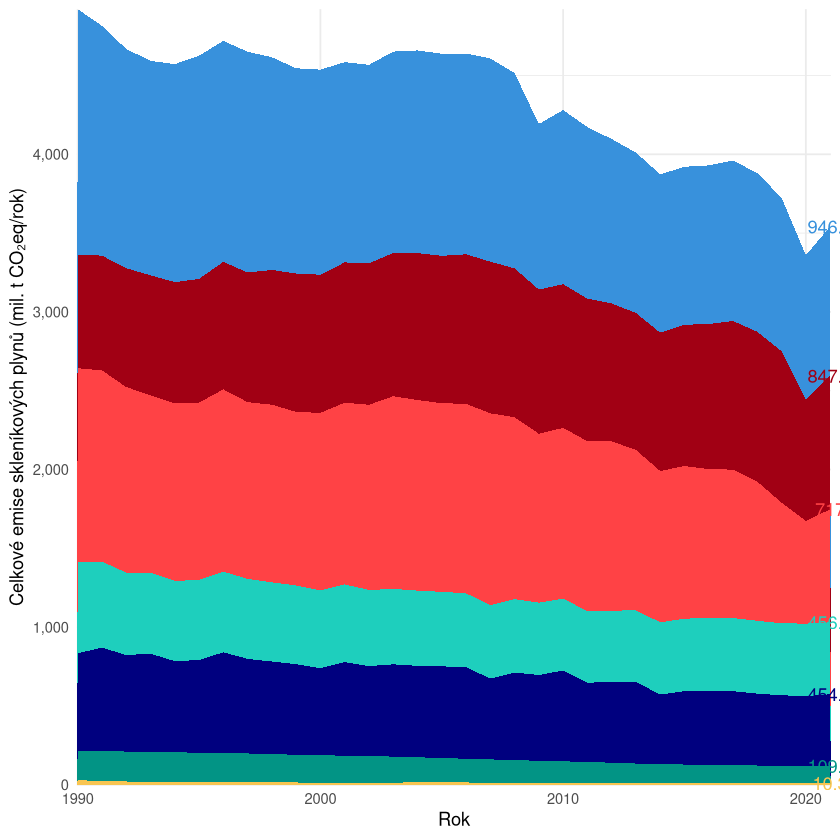

In [130]:
stacked_area <- selected_emissions |>
  ggplot(aes(Year, Value)) +
  geom_area(aes(fill = Category)) +
  geom_text(aes(colour = Category, label = round(Value, 1)),
            data = ~ filter(.x, Year == max(Year)),
            position = "stack") +
  scale_colour_manual(values = category_colours) +
  scale_fill_manual(values = category_colours) +
  scale_y_continuous(labels = scales::label_comma()) +
  coord_cartesian(clip = "off", expand = FALSE) +
  labs(x = "Rok",
       y = "Celkové emise skleníkových plynů (mil. t CO₂eq/rok)") +
  theme(panel.grid.minor.x = element_blank(),
        legend.position    = "none")

stacked_area

## Emissions change by category

Relative changes within a category are plotted as small multiples of line charts.

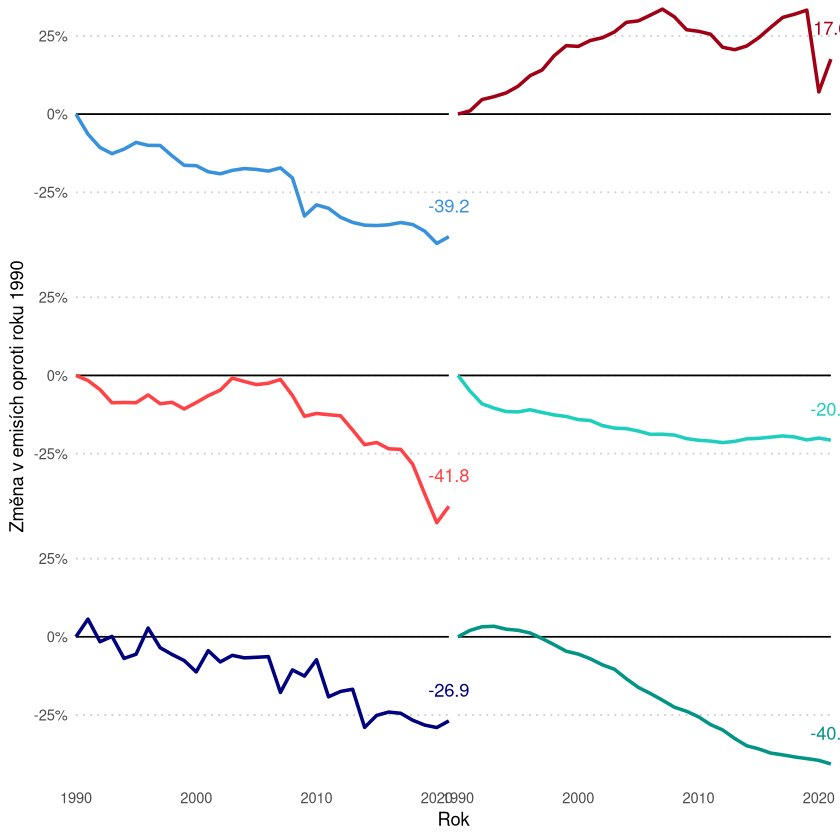

In [131]:
small_multiples <- selected_emissions |>
  filter(Category != "Other") |>
  ggplot(aes(Year, ChangePct_1990)) +
  geom_hline(yintercept = 0) +
  geom_line(aes(colour = Category), linewidth = 1) +
  geom_text(aes(colour = Category, label = round(100 * ChangePct_1990, 1)),
            data = ~ filter(.x, Year == max(Year)),
            nudge_y = .1) +
  scale_colour_manual(values = category_colours, guide = "none") +
  scale_y_continuous(labels = scales::label_percent(),
                     breaks = seq(-.5, .5, .25)) +
  coord_cartesian(clip = "off", expand = FALSE) +
  facet_wrap(vars(Category), ncol = 2) +
  labs(x = "Rok",
       y = "Změna v emisích oproti roku 1990") +
  theme(panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank(),
        panel.grid.major.y = element_line(colour   = scales::alpha("black", .2),
                                          linetype = 3),
        panel.grid.minor.y = element_blank(),
        strip.text         = element_blank())

small_multiples

In [ ]:
# Used for exports only.

# library(patchwork)
# svglite::svglite("EU.svg", width = 12, height = 8)
# stacked_area + small_multiples + plot_layout(widths = c(4, 3))
# dev.off()